<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/numerical_experiments/exp_3/exp_3_v5_frozen_ntk_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch

class BinaryDataset:
    def __init__(self, n, k, train_size, test_size, data_seed, normalize=False, device=None):
        self.n = n
        self.k = k
        self.train_size = train_size
        self.test_size = test_size
        self.data_seed = data_seed
        self.normalize = normalize
        self.device = device

        (self.train_inputs, self.train_outputs), (self.test_inputs, self.test_outputs) = self._prepare_data()

    def _prepare_data(self):
        np.random.seed(self.data_seed)
        total_size = self.train_size + self.test_size

        binary_strings = {tuple(np.random.randint(2, size=self.n)) for _ in range(total_size)}
        while len(binary_strings) < total_size:
            binary_strings.add(tuple(np.random.randint(2, size=self.n)))

        binary_strings = list(binary_strings)
        inputs = np.array(binary_strings, dtype=np.float32)
        outputs = np.sum(inputs[:, :self.k], axis=-1) % 2

        # # 出力ラベルを 0 -> -1, 1 -> 1 に変換（ヒンジ損失用）
        # outputs = 2 * outputs - 1

        # データの正規化を行う場合
        if self.normalize:
            inputs = (inputs - inputs.mean(axis=0))
            norm = np.linalg.norm(inputs, axis=1, keepdims=True)
            inputs = (inputs / np.maximum(norm, 1e-8))  # ゼロ除算防止

        indices = np.random.permutation(total_size)
        train_indices, test_indices = indices[:self.train_size], indices[self.train_size:]

        train_inputs = torch.tensor(inputs[train_indices], dtype=torch.float32).to(self.device)
        train_outputs = torch.tensor(outputs[train_indices], dtype=torch.float32).to(self.device)
        test_inputs = torch.tensor(inputs[test_indices], dtype=torch.float32).to(self.device)
        test_outputs = torch.tensor(outputs[test_indices], dtype=torch.float32).to(self.device)

        return (train_inputs, train_outputs), (test_inputs, test_outputs)

    def get_data(self):
        return (self.train_inputs, self.train_outputs), (self.test_inputs, self.test_outputs)


###################################################################

import functools
import math
import torch.nn as nn
import torch.nn.functional as F

class FC(nn.Module):
    def __init__(self, d, h, L, act, bias=False):
        super().__init__()

        hh = d
        for i in range(L):
            W = torch.randn(h, hh)

            n = max(1, 128 * 256 // hh)
            W = nn.ParameterList([nn.Parameter(W[j: j+n]) for j in range(0, len(W), n)])

            setattr(self, "W{}".format(i), W)
            if bias:
                self.register_parameter("B{}".format(i), nn.Parameter(torch.zeros(h)))
            hh = h

        self.register_parameter("W{}".format(L), nn.Parameter(torch.randn(1, hh)))
        if bias:
            self.register_parameter("B{}".format(L), nn.Parameter(torch.zeros(1)))

        self.L = L
        self.act = act
        self.bias = bias

    def forward(self, x):
        for i in range(self.L + 1):
            W = getattr(self, "W{}".format(i))

            if isinstance(W, nn.ParameterList):
                W = torch.cat(list(W))

            if self.bias:
                B = self.bias * getattr(self, "B{}".format(i))
            else:
                B = 0

            h = x.size(1)

            if i < self.L:
                x = x @ (W.t() / h ** 0.5)
                x = self.act(x + B)
            else:
                x = x @ (W.t() / h ** 0.5) + B

        return x.view(-1)

#################################################################################
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    r'''
    Compute the gradient of `outputs` with respect to `inputs`
    ```
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    ```
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

########################################################################################
def compute_kernels(f, xtr, xte):

    ktrtr = xtr.new_zeros(len(xtr), len(xtr))
    ktetr = xtr.new_zeros(len(xte), len(xtr))
    ktete = xtr.new_zeros(len(xte), len(xte))

    params = []
    current = []
    for p in sorted(f.parameters(), key=lambda p: p.numel(), reverse=True):
        current.append(p)
        if sum(p.numel() for p in current) > 2e9 // (8 * (len(xtr) + len(xte))):
            if len(current) > 1:
                params.append(current[:-1])
                current = current[-1:]
            else:
                params.append(current)
                current = []
    if len(current) > 0:
        params.append(current)

    for i, p in enumerate(params):
        print("[{}/{}] [len={} numel={}]".format(i, len(params), len(p), sum(x.numel() for x in p)), flush=True)

        jtr = xtr.new_empty(len(xtr), sum(u.numel() for u in p))  # (P, N~)
        jte = xte.new_empty(len(xte), sum(u.numel() for u in p))  # (P, N~)

        for j, x in enumerate(xtr):
            jtr[j] = gradient(f(x[None]), p)  # (N~)

        for j, x in enumerate(xte):
            jte[j] = gradient(f(x[None]), p)  # (N~)

        ktrtr.add_(jtr @ jtr.t())
        ktetr.add_(jte @ jtr.t())
        ktete.add_(jte @ jte.t())
        del jtr, jte

    return ktrtr, ktetr, ktete

# Frozen NTK dynamics

In [4]:
import copy
import itertools
import math
from time import perf_counter

def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step * (1 - math.exp(-t * rate / step)))

def train_kernel(args, ktrtr, ytr, tau, max_walltime, alpha, learning_rate, loss_prim, max_dgrad=math.inf, max_dout=math.inf):
    # 初期化
    otr = torch.zeros(len(ytr), dtype=ktrtr.dtype, device=ktrtr.device)
    gradient_update = torch.clone(otr)

    last_lr_change_step = 0  # 最後に学習率が変更されたステップ

    checkpoint_generator = loglinspace(0.01, 100)
    checkpoint = next(checkpoint_generator)  # 最初のチェックポイント
    start_time = perf_counter()  # 経過時間計測の開始
    converged = False

    # 初期の損失関数の勾配を計算
    lprim = loss_prim(otr, ytr)
    grad = ktrtr @ lprim / len(ytr)

    # メインループ
    for step in itertools.count():
        if step >= args.max_step:
            break

        # 現在の状態を保存
        state = copy.deepcopy((otr, gradient_update))

        while True:
            gradient_update = -grad.clone()

            # 出力を更新
            otr = otr + learning_rate * gradient_update

            # 新しい勾配を計算
            lprim = loss_prim(otr, ytr)
            new_grad = ktrtr @ lprim / len(ytr)

            # 出力変化量 (dout) の計算
            dout = (learning_rate * alpha * gradient_update).abs().max().item()

            # 勾配の変化量 (dgrad) の計算
            if grad.norm() == 0 or new_grad.norm() == 0:
                dgrad = 0
            else:
                dgrad = ((grad - new_grad).norm() ** 2 / (grad.norm() * new_grad.norm())).item()

            # 変化量が許容範囲内なら学習率を調整
            if dgrad < max_dgrad and dout < max_dout:
                if dgrad < 0.1 * max_dgrad and dout < 0.1 * max_dout:
                    learning_rate *= 1.1  # 学習率を大きくする
                break

            # 学習率を小さくする
            learning_rate /= 10

            print("[Step {:d}/{:d}] [Progress: {:.2%}] [learning rate: {:.1e}]".format(step, args.max_step, step / args.max_step, learning_rate), flush=True)

            # 状態をリセット
            last_lr_change_step = step
            otr, gradient_update = state

        # 勾配を更新
        grad = new_grad

        save = False
        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        if save:
            state = {
                'step': step,
                'wall': perf_counter() - start_time,
                'learning_rate': learning_rate,
                'dgrad': dgrad,
                'dout': dout,
                'grad_norm': grad.norm().item(),
            }
            yield otr, gradient_update, grad, state, converged

        if converged:
            break

        # 最大経過時間を超えたら終了
        if perf_counter() > start_time + max_walltime:
            break

        # 出力に NaN が含まれていたら終了
        if torch.isnan(otr).any():
            break

In [10]:
import torch
import torch.nn.functional as F
import os
from functools import partial
from time import perf_counter

class Args:
    def __init__(self):
        self.device = 'cpu'
        self.init_seed = 0
        self.data_seed = 0
        self.batch_seed = 0
        self.max_step = 50000
        self.n = 13
        self.k = 3
        self.train_size = 3000
        self.test_size = 1900
        self.normalize = False
        self.bias = True
        self.L = 3
        self.h = 100
        self.learning_rate = 0.01
        self.init_kernel = 1
        self.store_kernel = 0
        self.delta_kernel = 0
        self.save_outputs = 0
        self.alpha = 1
        self.f0 = 1
        self.train_time = 18000
        self.max_dgrad = 1e-4
        self.max_dout = 0.1
        self.loss = 'cross_entropy'
        self.pickle = 'results.pkl'
        self.track_test_metrics = True

def loss_func(args, outputs, targets):
    if args.loss == 'mse':
        return ((targets - outputs) ** 2).mean()
    elif args.loss == 'cross_entropy':
        return F.binary_cross_entropy_with_logits(outputs, targets)

def loss_func_prime(args, outputs, targets):
    if args.loss == 'mse':
        return -2 * (targets - outputs) / outputs.size(0)
    elif args.loss == 'cross_entropy':
        probs = torch.sigmoid(outputs)
        grad = probs - targets
        return grad / outputs.size(0)

def run_kernel(args, ktrtr, ktetr, ktete, f, xtr, ytr, xte, yte):
    assert args.f0 == 1

    dynamics = []
    step_counter = 0

    tau = 0

    for otr, _gradient_update, _grad, state, _converged in train_kernel(args, ktrtr, ytr, tau, args.train_time, args.alpha, args.learning_rate, partial(loss_func_prime, args), args.max_dgrad, args.max_dout):
        step_counter += 1

        preds = torch.sigmoid(otr) > 0.5
        train_accuracy = (preds.int() == ytr.int()).float().mean().item()

        state['train'] = {
            'loss': loss_func(args, otr, ytr).item(),
            'aloss': args.alpha * loss_func(args, otr, ytr).item(),
            'accuracy': train_accuracy,
            'dfnorm': otr.pow(2).mean().sqrt(),
            'outputs': otr if args.save_outputs else None,
            'labels': ytr if args.save_outputs else None,
        }

        if args.track_test_metrics and step_counter % 50 == 0:
            c = torch.linalg.lstsq(ktrtr, otr.view(-1, 1)).solution.flatten()

            if len(xte) > len(xtr):
                a = gradient(f(xtr) @ c, f.parameters())
                ote = torch.stack([gradient(f(x[None]), f.parameters()) @ a for x in xte])
            else:
                ote = ktetr @ c

            test_loss = loss_func(args, ote, yte).item()
            test_preds = torch.sigmoid(ote) > 0.5
            test_accuracy = (test_preds.int() == yte.int()).float().mean().item()

            state['test'] = {
                'loss': test_loss,
                'accuracy': test_accuracy,
            }

            print(f"[Step {state['step']:d}/{args.max_step}] [Time: {state['wall']:.0f}s] "
                  f"[Train Loss: {state['train']['loss']:.2e}] [Train Acc: {state['train']['accuracy']:.2f}] "
                  f"[Eval Loss: {state['test']['loss']:.2e}] [Eval Acc: {state['test']['accuracy']:.2f}]",
                  flush=True)
        else:
            state['test'] = {
                'loss': None,
                'accuracy': None,
            }

            print(f"[Step {state['step']:d}/{args.max_step}] [Time: {state['wall']:.0f}s] "
                  f"[Train Loss: {state['train']['aloss']:.2e}] [Train Acc: {state['train']['accuracy']:.2f}]",
                  flush=True)

        dynamics.append(state)

    c = torch.linalg.lstsq(ktrtr, otr.view(-1, 1)).solution.flatten()
    if len(xte) > len(xtr):
        a = gradient(f(xtr) @ c, f.parameters())
        ote = torch.stack([gradient(f(x[None]), f.parameters()) @ a for x in xte])
    else:
        ote = ktetr @ c

    final_test_loss = loss_func(args, ote, yte).item()
    final_test_preds = torch.sigmoid(ote) > 0.5
    final_test_accuracy = (final_test_preds.int() == yte.int()).float().mean().item()

    dynamics[-1]['test'] = {
        'loss': final_test_loss,
        'accuracy': final_test_accuracy,
    }

    out = {
        'dynamics': dynamics,
        'train': {
            'outputs': otr,
            'labels': ytr,
        },
        'test': {
            'outputs': ote,
            'labels': yte,
        },
        'kernel': {
            'train': {
                'value': ktrtr.cpu() if args.store_kernel == 1 else None,
            },
            'test': {
                'value': ktete.cpu() if args.store_kernel == 1 else None,
            },
        },
    }

    return out

def execute(args):
    torch.set_default_dtype(torch.float64)

    dataset = BinaryDataset(args.n, args.k, args.train_size, args.test_size, args.data_seed, args.normalize, args.device)
    (xtr, ytr), (xte, yte) = dataset.get_data()

    xtr = xtr.type(torch.get_default_dtype())
    xte = xte.type(torch.get_default_dtype())
    ytr = ytr.type(torch.get_default_dtype())
    yte = yte.type(torch.get_default_dtype())

    torch.manual_seed(args.init_seed + hash(args.alpha))

    act = lambda x: 2 ** 0.5 * torch.relu(x)

    xtr = xtr.flatten(1)
    xte = xte.flatten(1)
    f = FC(xtr.size(1), args.h, args.L, act, args.bias).to(args.device)

    if args.delta_kernel == 1 or args.init_kernel == 1:
        init_kernel = compute_kernels(f, xtr, xte[:len(xtr)])

    results = {}

    if args.init_kernel == 1:
        results['init_kernel'] = run_kernel(args, *init_kernel, f, xtr, ytr, xte, yte)

    if args.delta_kernel == 1:
        init_kernel = (init_kernel[0].cpu(), init_kernel[2].cpu())
    elif args.init_kernel == 1:
        del init_kernel

    return {
        'args': args,
        'results': results
    }


#####################################

args = Args()
results_to_save = {'args': args}

try:
    results = execute(args)
    results_to_save.update(results)

    with open(args.pickle, 'wb') as f:
        torch.save(results_to_save, f)
except:
    os.remove(args.pickle)
    raise

[0/1] [len=8 numel=21701]
[Step 0/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.56]
[Step 1/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 2/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 3/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 4/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 5/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 6/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 7/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 8/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 9/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 10/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 11/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 12/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 13/50000] [Time: 0s] [Train Loss: 6.93e-01] [Train Acc: 0.55]
[Step 14/50000] [Time: 0s] [Trai

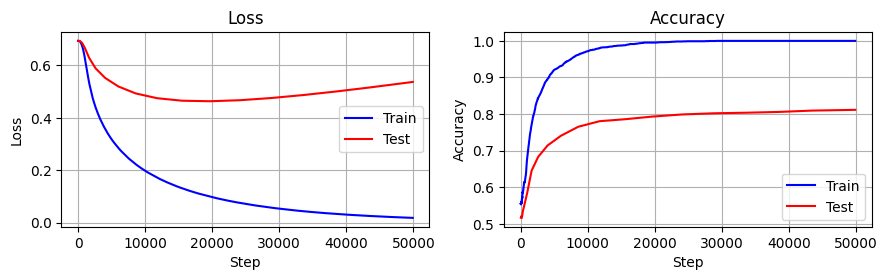


First 100 Train Outputs:
tensor([ 4.0999, 10.6976, -8.1954,  5.1052,  2.8697, -4.4068, -6.3147,  6.0378,
         2.4296, 10.0488,  6.9851,  5.8553,  2.9275, -3.5722, -6.6971,  5.6129,
        -3.9293,  7.4895, -8.3202,  8.9021,  4.3730, -4.2496,  5.2632,  4.1506,
        -6.3656,  4.2507,  6.3276,  5.9729,  9.0542, 12.8752,  4.5688, -6.5302,
         3.3858,  4.5987, -3.9050,  2.9038,  9.9248, -3.7602,  4.6794,  3.0108,
        -2.9973,  8.6436, -8.0231, -3.9981, -3.0180, -4.1971,  5.1085,  7.0803,
        -2.4777,  9.9244, -4.0420, -4.2431, -3.2173,  2.4373, -8.4628,  7.8628,
         7.7868, -2.3718,  5.5413, -3.2111, -5.6477, -3.9670,  5.2310,  5.0469,
        -8.9229, -5.4001, 10.0655, -9.2351, -6.1677,  2.4222, -3.6902,  2.5976,
         3.6994,  3.5264, 17.4848, -5.9011,  5.7861,  4.8138, 10.6870,  5.1747,
        -3.8577,  7.4492,  3.1736,  8.5590,  4.1335,  2.9618, -7.1389,  4.9187,
         2.8368, -3.1706,  4.2960,  3.1222,  6.3031, -4.6146,  3.3783, -2.9741,
        -2.964

In [11]:
import matplotlib.pyplot as plt
import torch
import pickle

def load_results(filename):
    with open(filename, 'rb') as f:
        data = torch.load(f, weights_only=False)
    args = data.get('args', None)
    results = data.get('results', None)

    if results is None:
        print(f"No results found in {filename}")
        return None, None

    if 'init_kernel' in results:
        dynamics = results['init_kernel'].get('dynamics', [])
        final_results = results['init_kernel']
    else:
        print(f"No 'init_kernel' key found in {filename}")
        return None, None

    return args, final_results, dynamics

def plot_training_results(args, dynamics):
    if args is None or dynamics is None:
        print("No data to plot.")
        return

    steps = [state['step'] for state in dynamics]
    train_losses = [state['train']['loss'] for state in dynamics]
    train_accuracies = [state['train']['accuracy'] for state in dynamics]

    plt.figure(figsize=(9, 5))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(steps, train_losses, label='Train', color='blue')
    if args.track_test_metrics:
        test_steps = [state['step'] for state in dynamics if state['test']['loss'] is not None]
        test_losses = [state['test']['loss'] for state in dynamics if state['test']['loss'] is not None]
        plt.plot(test_steps, test_losses, label='Test', color='red')
    plt.xlabel('Step')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(steps, train_accuracies, label='Train', color='blue')
    if args.track_test_metrics:
        test_steps = [state['step'] for state in dynamics if state['test']['accuracy'] is not None]
        test_accuracies = [state['test']['accuracy'] for state in dynamics if state['test']['accuracy'] is not None]
        plt.plot(test_steps, test_accuracies, label='Test', color='red')
    plt.xlabel('Step')
    # plt.xscale('log')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# テストとトレーニングの出力とラベルの最初の100個を表示する関数
def print_outputs_labels(final_results, num_samples=100):
    # Training data display
    if final_results is None or 'train' not in final_results:
        print("No train results found in the final results.")
    else:
        train_outputs = final_results['train']['outputs']
        train_labels = final_results['train']['labels']

        if train_outputs is not None and train_labels is not None:
            print(f"\nFirst {num_samples} Train Outputs:")
            print(train_outputs[:num_samples])

            print(f"\nFirst {num_samples} Train Labels:")
            print(train_labels[:num_samples])
        else:
            print("Train outputs or labels not found.")

    # Test data display
    if final_results is None or 'test' not in final_results:
        print("No test results found in the final results.")
    else:
        test_outputs = final_results['test']['outputs']
        test_labels = final_results['test']['labels']

        if test_outputs is not None and test_labels is not None:
            print(f"\nFirst {num_samples} Test Outputs:")
            print(test_outputs[:num_samples])

            print(f"\nFirst {num_samples} Test Labels:")
            print(test_labels[:num_samples])
        else:
            print("Test outputs or labels not found.")

filename = 'results.pkl'
args, final_results, dynamics = load_results(filename)


plot_training_results(args, dynamics)

# トレーニングとテスト出力とラベルの最初の100個を表示
print_outputs_labels(final_results, num_samples=100)


# Calculate and display final test accuracy
if final_results is not None and 'test' in final_results:
    test_outputs = final_results['test']['outputs']
    test_labels = final_results['test']['labels']
    if test_outputs is not None and test_labels is not None:
        test_preds = torch.sigmoid(test_outputs) > 0.5
        test_accuracy = (test_preds.int() == test_labels.int()).float().mean().item()
        print(f"Final Test Accuracy: {test_accuracy:.4f}")
    else:
        print("Test outputs or labels not found.")
else:
    print("No test results found in the final results.")